## Exploratory Data Analysis: Speech Emotion Recognition on EmoDB



#### Libraries

In [14]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
import pandas as pd
import numpy as np
import librosa
import importlib
import os
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as patches

In [16]:
from data_function import *

#### Loading Data

##### Loading Data from EmoDB Dataset

In [17]:
# Load data from EmoDB

df_emoDB = load_dataset_emoDB()

df_emoDB.head()

,label,path,duration,sample_rate,gender
0,happy,EmoDB\wav\03a01Fa.wav,1.898250,16000,male
1,neutral,EmoDB\wav\03a01Nc.wav,1.611250,16000,male
2,angry,EmoDB\wav\03a01Wa.wav,1.877813,16000,male
3,happy,EmoDB\wav\03a02Fc.wav,2.006250,16000,male
4,neutral,EmoDB\wav\03a02Nc.wav,1.439812,16000,male


##### Loading Data from RAVDESS Dataset

**Down-sampling Audio from RAVDESS Dataset**: The original sampling rate of RAVDESS is 48.000Hz, we need to down sampling the sampling rate to maintain consistency across all audio samples with EmoDB Dataset. 

In [18]:
# Load RAVDESS dataset 

df_RAVDESS = load_dataset_RAVDESS()

df_RAVDESS.head()

,label,path,duration,sample_rate,gender
0,neutral,RAVDESS\Actor_01\03-01-01-01-01-01-01.wav,3.303313,16000,male
1,neutral,RAVDESS\Actor_01\03-01-01-01-01-02-01.wav,3.336688,16000,male
2,neutral,RAVDESS\Actor_01\03-01-01-01-02-01-01.wav,3.269938,16000,male
3,neutral,RAVDESS\Actor_01\03-01-01-01-02-02-01.wav,3.169875,16000,male
4,calm,RAVDESS\Actor_01\03-01-02-01-01-01-01.wav,3.536875,16000,male


#### Overview Information

In [21]:
# Basic information for EmoDB Dataset
print("---EmoDB Dataset---")

# Number of audio files
print("Total audio files:", len(df_emoDB))

# Check Sampling Rate Consistency
print("Sampling rate counts:", df_emoDB['sample_rate'].value_counts().to_dict())

# Emotion Class
print("Number of Emotion: ", df_emoDB['label'].nunique())
print(df_emoDB['label'].unique())

# Check 'unknown' Emotion
print("Number of 'unknown' Emotion Audio: ", sum(df_emoDB['label'] == 'unknown'))

---EmoDB Dataset---
Total audio files: 535
Sampling rate counts: {16000: 535}
Number of Emotion:  7
['happy' 'neutral' 'angry' 'sad' 'fearful' 'bored' 'disgust']
Number of 'unknown' Emotion Audio:  0



&rarr; All `535` audio files have a consistent sampling rate of 16,000 Hz.  
&rarr; There are 0 audio samples labeled as 'unknown', indicating that the emotion labels are complete and well-annotated.

In [22]:
# Basic information for RAVDESS Dataset
print("---RAVDESS Dataset---")

# Number of audio files
print("Total audio files:", len(df_RAVDESS))

# Check Sampling Rate Consistency
print("Sampling rate counts:", df_RAVDESS['sample_rate'].value_counts().to_dict())

# Emotion Class
print("Number of Emotion: ", df_emoDB['label'].nunique())
print(df_emoDB['label'].unique())

# Check 'unknown' Emotion
print("Number of 'unknown' Emotion Audio: ", sum(df_RAVDESS['label'] == 'unknown'))

---RAVDESS Dataset---
Total audio files: 1440
Sampling rate counts: {16000: 1440}
Number of Emotion:  7
['happy' 'neutral' 'angry' 'sad' 'fearful' 'bored' 'disgust']
Number of 'unknown' Emotion Audio:  0


#### Class Distribution

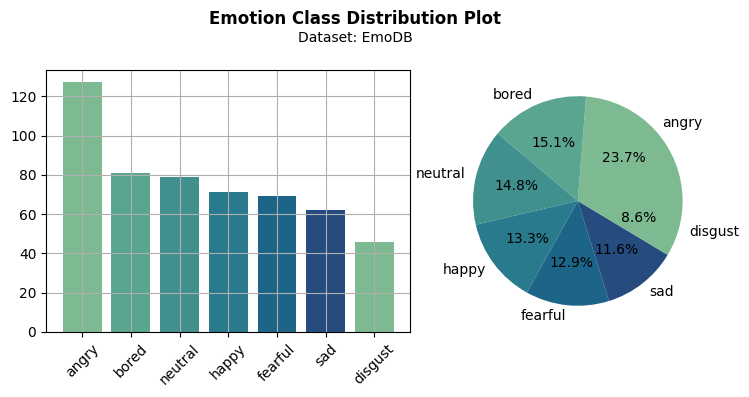

In [8]:
draw_class_distribution(dataframe=df_emoDB, title='Emotion Class Distribution Plot', source='Dataset: EmoDB')

**Note**: `anger` is the most frequent emotion, while `disgust` is the least.  
&rarr; This class imbalance should be addressed during model development (e.g., with class weighting or data augmentation).

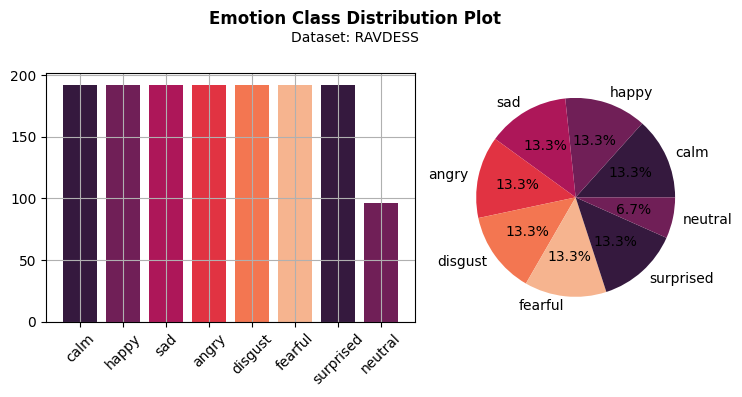

In [ ]:
draw_class_distribution(dataframe=df_RAVDESS, title='Emotion Class Distribution Plot', source='Dataset: RAVDESS', color_palette='rocket')

**Problem**: There are some unique emtion from each Dataset that can not be combined with the other data set. 

#### Audio Duration Distribution

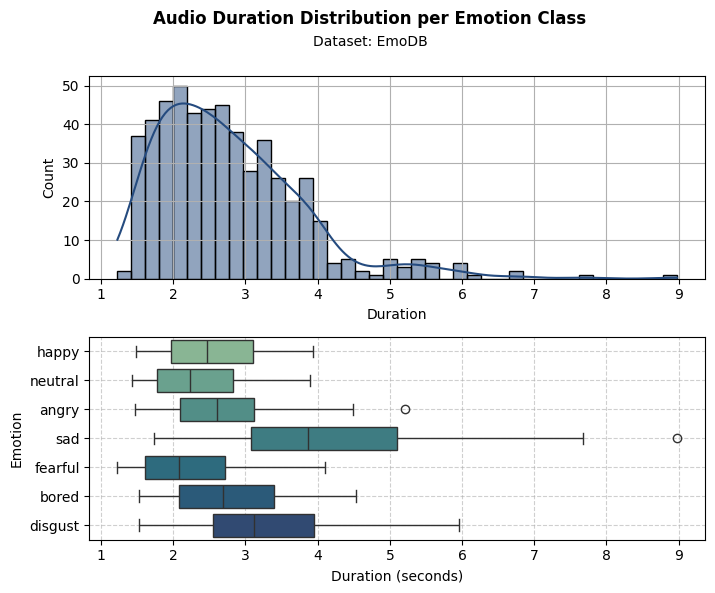

<Figure size 640x480 with 0 Axes>

In [ ]:
draw_duration_distribution(df_emoDB, source='Dataset: EmoDB')

- Most audio samples range between **2 to 4 seconds**, though some longer outliers exist (e.g., sadness up to ~9s).
- `sadness` has the **widest duration spread**, indicating more variability in expression length.
- `anger`, `neutral`, and `happiness` have relatively consistent durations with compact interquartile ranges.
- `disgust` and `boredom` tend to have shorter and more consistent audio durations.

> This analysis suggests that emotion types may affect how long a person speaks, which could be a useful signal for modeling or preprocessing.

In [ ]:
outliers = df_emoDB[df_emoDB['duration'] > 8]

outliers = outliers['path'].tolist()

In [57]:
from IPython.display import Audio

Audio(outliers[0])

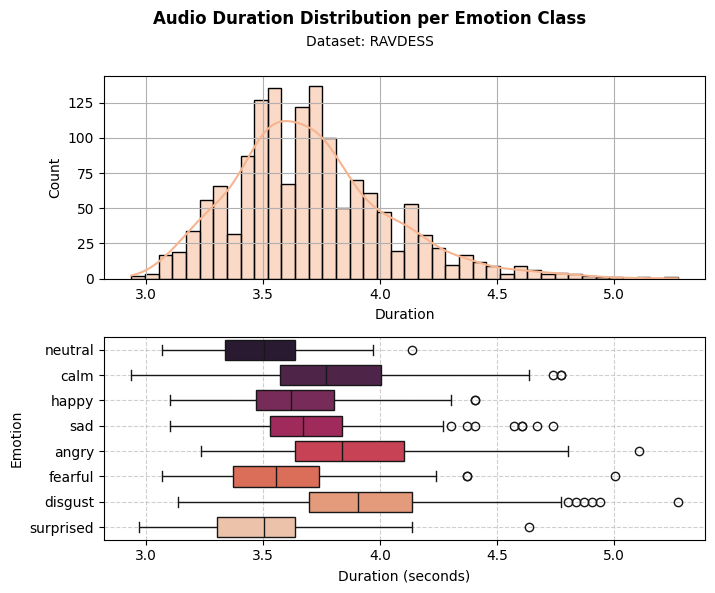

<Figure size 640x480 with 0 Axes>

In [28]:
from data_function import *

draw_duration_distribution(dataframe=df_RAVDESS, source="Dataset: RAVDESS", color_palette='rocket')

- Most audio clips have durations between **3.3 to 3.8** seconds.  
- The distribution is right-skewed, meaning there are a few longer audio clips (above 4.5 seconds).  
- The KDE curve confirms a single peak around 3.6 seconds, suggesting that’s the most common duration.  
- Emotions like `disgust` and surprised might require special handling due to higher variance and outliers.


&rarr; There is emotion-specific variation in duration—important if using duration as a feature for emotion classification.

#### Gender Distribution

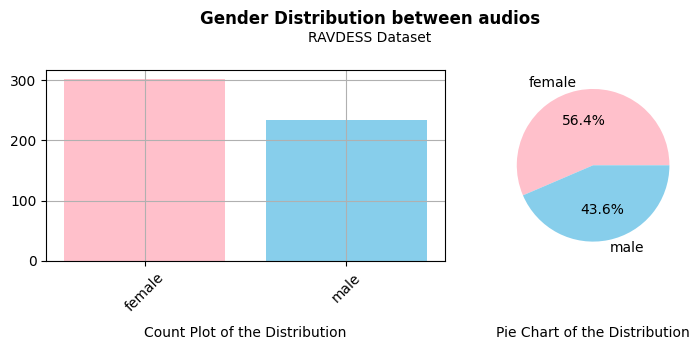

In [48]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 4))
colors = sns.color_palette('crest')

gender_count_emoDB = df_emoDB['gender'].value_counts().to_dict()

ax1.bar(gender_count_emoDB.keys(), gender_count_emoDB.values(), color=['pink', 'skyblue'])
ax1.tick_params(axis='x', labelrotation=45)
ax1.grid(True)  
ax1.text(0.5, -0.4, 'Count Plot of the Distribution', 
        transform=ax1.transAxes, ha='center', fontsize=10)

ax2.pie(gender_count_emoDB.values(), labels=gender_count_emoDB.keys(), autopct='%1.1f%%', colors=['pink', 'skyblue'])
ax2.grid(True)

ax2.text(0.5, -0.4, 'Pie Chart of the Distribution', 
        transform=ax2.transAxes, ha='center', fontsize=10)

fig.suptitle('Gender Distribution between audios', fontweight='bold',  ha='center')
fig.text(0.5, 0.9, 'RAVDESS Dataset', ha='center', fontsize=10)

plt.tight_layout(rect=[0.2, 0, 0.85, 0.95])
plt.show()

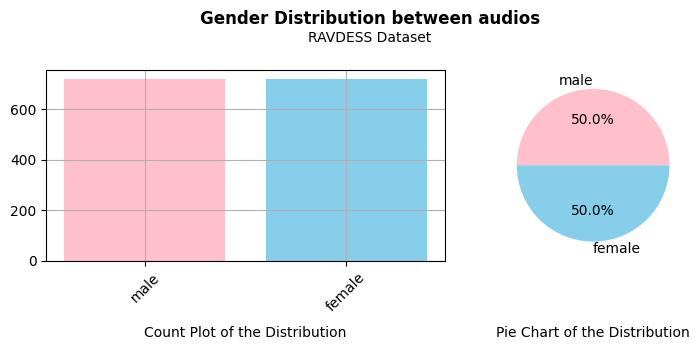

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12.5, 4))
colors = sns.color_palette('crest')

gender_count_RAVDESS = df_RAVDESS['gender'].value_counts().to_dict()

ax1.bar(gender_count_RAVDESS.keys(), gender_count_RAVDESS.values(), color=['pink', 'skyblue'])
ax1.tick_params(axis='x', labelrotation=45)
ax1.grid(True)  
ax1.text(0.5, -0.4, 'Count Plot of the Distribution', 
        transform=ax1.transAxes, ha='center', fontsize=10)

ax2.pie(gender_count_RAVDESS.values(), labels=gender_count_RAVDESS.keys(), autopct='%1.1f%%', colors=['pink', 'skyblue'])
ax2.grid(True)

ax2.text(0.5, -0.4, 'Pie Chart of the Distribution', 
        transform=ax2.transAxes, ha='center', fontsize=10)

fig.suptitle('Gender Distribution between audios', fontweight='bold',  ha='center')
fig.text(0.5, 0.9, 'RAVDESS Dataset', ha='center', fontsize=10)

plt.tight_layout(rect=[0.2, 0, 0.85, 0.95])
plt.show()

#### Waveform Visualization

In [183]:
emotion_samples_emoDB = {}

for emotion in df_emoDB['emotion'].unique():
    sample_row = df_emoDB[df_emoDB['emotion'] == emotion].iloc[0]
    emotion_samples_emoDB[emotion] = sample_row['filename']

In [188]:
emotion_samples_RAVDESS = {}

for emotion in df_RAVDESS['emotion'].unique():
    sample_row = df_RAVDESS[df_RAVDESS['emotion'] == emotion].iloc[0]
    emotion_samples_RAVDESS[emotion] = sample_row['filename']

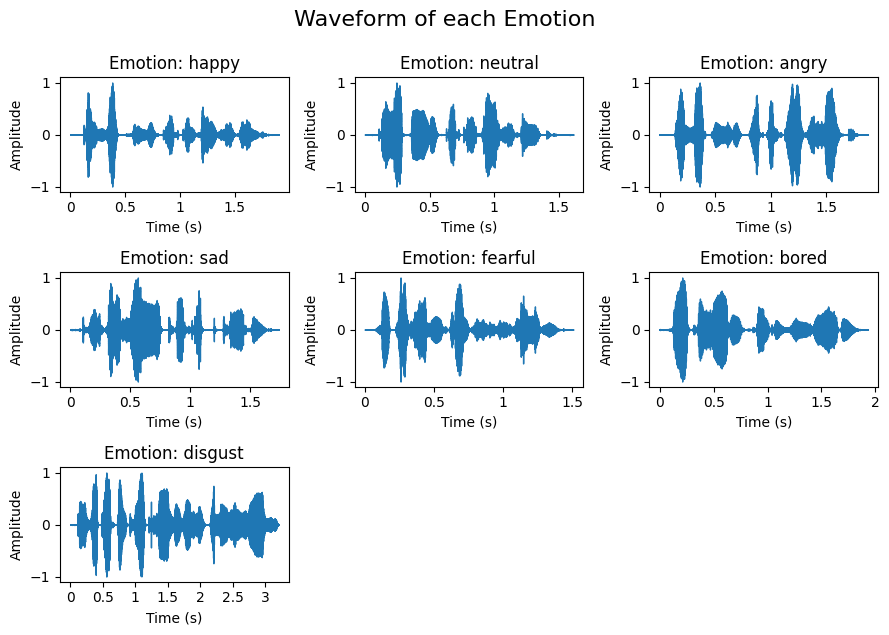

In [185]:
plt.figure(figsize=(9, 6))

for idx, (emotion, fname) in enumerate(emotion_samples_emoDB.items()):
    file_path = os.path.join(EmoDB_folder_path, fname)
    y, sr = librosa.load(file_path, sr=None)

    plt.subplot(3, 3, idx + 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Emotion: {emotion}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.suptitle("Waveform of each Emotion", fontsize=16, y=1.05)
plt.show()

In [ ]:
plt.figure(figsize=(9, 6))

for idx, (emotion, fname) in enumerate(emotion_samples_RAVDESS.items()):
    file_path = os.path.join(EmoDB_folder_path, fname)
    y, sr = librosa.load(file_path, sr=None)

    plt.subplot(3, 3, idx + 1)
    librosa.display.waveshow(y, sr=sr)
    plt.title(f"Emotion: {emotion}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.suptitle("Waveform of each Emotion", fontsize=16, y=1.05)
plt.show()

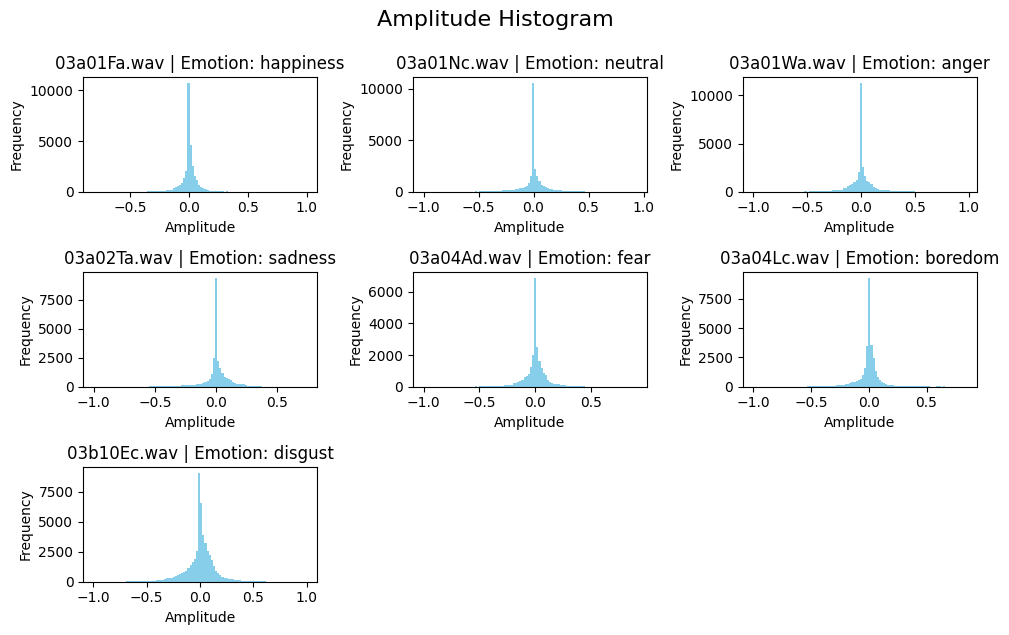

In [101]:
plt.figure(figsize=(10, 6))

for idx, (emotion, fname) in enumerate(emotion_samples.items()):
    file_path = os.path.join(EmoDB_folder_path, fname)
    y, sr = librosa.load(file_path, sr=None)

    plt.subplot(3, 3, idx + 1)
    plt.hist(y, bins=100, color='skyblue')
    plt.title(f"{fname} | Emotion: {emotion}")
    plt.xlabel("Amplitude")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.suptitle("Amplitude Histogram", fontsize=16, y=1.05)
plt.show()



#### Spectrogram

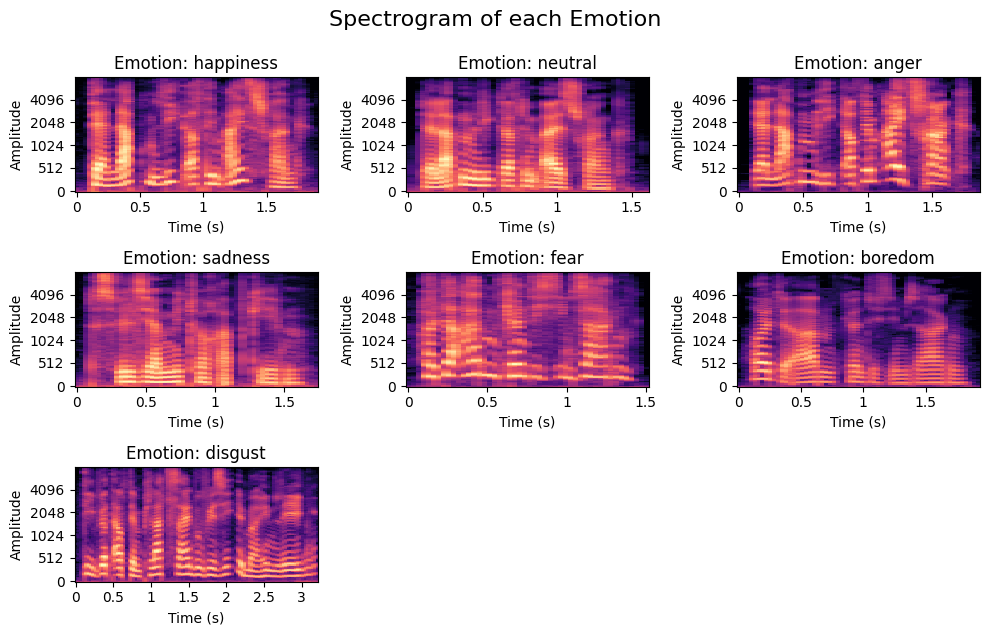

In [109]:
plt.figure(figsize=(10, 6))

for idx, (emotion, fname) in enumerate(emotion_samples.items()):
    file_path = os.path.join(EmoDB_folder_path, fname)
    y, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128, fmax=8000)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    plt.subplot(3, 3, idx + 1)
    librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000, cmap='magma')
    plt.title(f"Emotion: {emotion}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")

plt.tight_layout()
plt.suptitle("Spectrogram of each Emotion", fontsize=16, y=1.05)
plt.show()

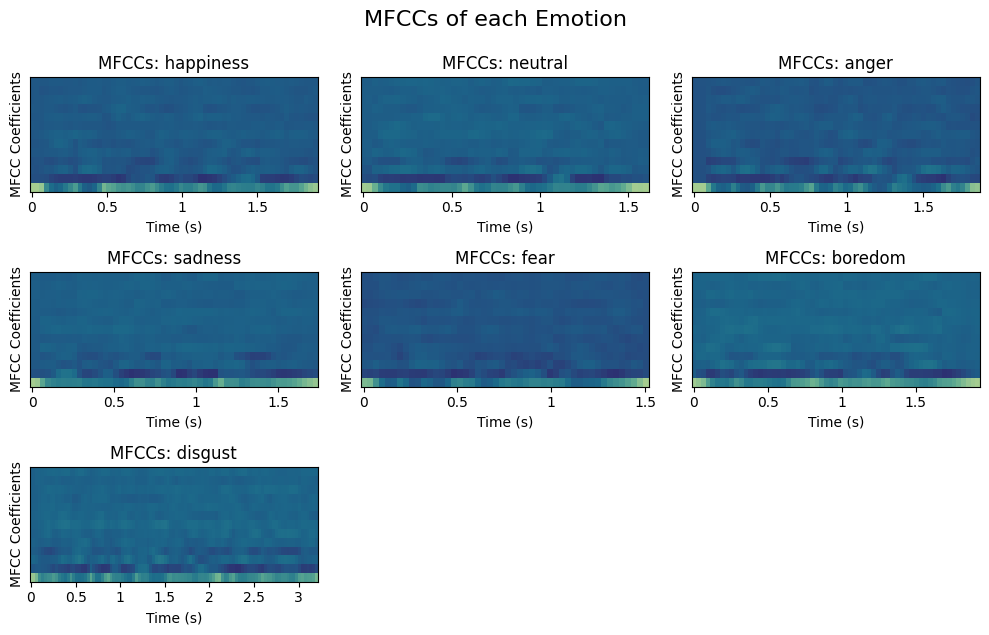

In [111]:
plt.figure(figsize=(10, 6))

for idx, (emotion, fname) in enumerate(emotion_samples.items()):
    file_path = os.path.join(EmoDB_folder_path, fname)
    y, sr = librosa.load(file_path, sr=None)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    plt.subplot(3, 3, idx + 1)
    librosa.display.specshow(mfccs, sr=sr, x_axis='time', cmap='crest')
    plt.title(f"MFCCs: {emotion}")
    plt.xlabel("Time (s)")
    plt.ylabel("MFCC Coefficients")

plt.tight_layout()
plt.suptitle("MFCCs of each Emotion", fontsize=16, y=1.05)
plt.show()

In [12]:
duration_stats = df.groupby('emotion')['duration'].describe()
print(duration_stats)

           count      mean       std       min       25%       50%       75%  \
emotion                                                                        
anger      127.0  2.640795  0.728803  1.465812  2.090094  2.609875  3.116937   
boredom     81.0  2.778977  0.804450  1.520063  2.074688  2.690562  3.398750   
disgust     46.0  3.352834  1.073298  1.523813  2.552859  3.117188  3.943766   
fear        69.0  2.233377  0.637358  1.225500  1.607938  2.081313  2.711750   
happiness   71.0  2.543967  0.682695  1.481375  1.963625  2.463563  3.106813   
neutral     79.0  2.359236  0.659165  1.430813  1.769750  2.235500  2.822000   
sadness     62.0  4.052895  1.532625  1.735688  3.076344  3.863375  5.102375   

                max  
emotion              
anger      5.213500  
boredom    4.525812  
disgust    5.963813  
fear       4.101375  
happiness  3.930938  
neutral    3.899188  
sadness    8.978250  
